In [32]:
import ray
from ray.rllib.env import PettingZooEnv
from ray.tune.registry import register_env
from pettingzoo.classic import texas_holdem_v4
from collections import OrderedDict

def env_creator(_config=None):
    # raw PettingZoo AEC env
    env = texas_holdem_v4.env()
    # RLlib wrapper so it looks like a MultiAgentEnv
    return PettingZooEnv(env)

env_name = "texas_holdem_v4"
register_env(env_name, lambda config: env_creator(config))

# Create one test env to grab spaces
test_env = env_creator()
obs_space = test_env.observation_space
act_space = test_env.action_space

In [33]:
test_env = texas_holdem_v4.env(render_mode="human")
test_env.reset()
obs, reward, termination, truncation, info = test_env.last()

print("obs['observation'].shape:", obs["observation"].shape)
print("obs['action_mask']:", obs["action_mask"])

obs['observation'].shape: (72,)
obs['action_mask']: [1 1 1 0]


In [34]:
from pettingzoo.classic import texas_holdem_v4

env = texas_holdem_v4.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        mask = observation["action_mask"]
        # this is where you would insert your policy
        action = env.action_space(agent).sample(mask)

    env.step(action)
env.close()


In [35]:
obs_space

Dict('player_0': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)), 'player_1': Dict('action_mask': Box(0, 1, (4,), int8), 'observation': Box(0.0, 1.0, (72,), float32)))

In [36]:
act_space

Dict('player_0': Discrete(4), 'player_1': Discrete(4))

In [37]:
import numpy as np
import gymnasium as gym
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch

torch, nn = try_import_torch()


class FlatActionMaskingModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        print(">>> FlatActionMaskingModel obs_space:", obs_space)
        print(">>> type(obs_space):", type(obs_space))

        if not isinstance(obs_space, gym.spaces.Box):
            raise ValueError(
                f"Expected flat Box obs space, got {obs_space!r} "
                f"(type={type(obs_space)})"
            )

        flat_dim = int(np.prod(obs_space.shape))
        mask_dim = action_space.n          # Discrete(4) -> 4
        obs_dim = flat_dim - mask_dim

        if obs_dim <= 0:
            raise ValueError(
                f"flat_dim ({flat_dim}) <= mask_dim ({mask_dim}); "
                f"can't split into obs + mask."
            )

        self.obs_dim = obs_dim
        self.mask_dim = mask_dim

        # Build a base FC net over the obs part only
        obs_low = np.full((obs_dim,), obs_space.low.min(), dtype=np.float32)
        obs_high = np.full((obs_dim,), obs_space.high.max(), dtype=np.float32)
        obs_box = gym.spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        self.base_model = FullyConnectedNetwork(
            obs_space=obs_box,
            action_space=action_space,
            num_outputs=num_outputs,  # should be 4
            model_config=model_config,
            name=name + "_fcnet",
        )

    def forward(self, input_dict, state, seq_lens):
        x = input_dict["obs"]

        # 情况 1：obs 是 Dict / OrderedDict，形如：
        # {"action_mask": tensor(...), "observation": tensor(...)}
        if isinstance(x, (dict, OrderedDict)):
            mask = x["action_mask"].float()      # [B, 4]
            obs  = x["observation"].float()      # [B, obs_dim]

        # 情况 2：obs 已经是 flatten 好的一维向量 [mask(4), obs(...)]
        else:
            flat = x.float()                     # [B, flat_dim]
            mask = flat[..., :self.mask_dim]     # [B, 4]
            obs  = flat[..., self.mask_dim:]     # [B, obs_dim]

        # 强制 mask 0/1
        legal_mask = (mask > 0.5).float()

        # 基础网络只看 obs 部分
        logits, _ = self.base_model({"obs": obs}, state, seq_lens)  # [B, 4]

        # 对非法动作加 -inf
        inf = torch.finfo(logits.dtype).min
        mask_add = (1.0 - legal_mask) * inf
        masked_logits = logits + mask_add

        return masked_logits, state



    def value_function(self):
        return self.base_model.value_function()


# ⬇️ 关键：一定要有这一行，并且名字完全一致
ModelCatalog.register_custom_model("flat_action_mask_model", FlatActionMaskingModel)


In [38]:
import numpy as np
from ray.rllib.policy.policy import Policy

class MaskedRandomPolicy(Policy):
    """
    一个简单的随机对手：
    - 输入 obs 已经是 RLlib flatten 后的一维向量（和 FlatActionMaskingModel 一样）
    - 向量前 action_space.n 维是 action_mask
    - 在合法动作里均匀随机选一个
    """
    def __init__(self, observation_space, action_space, config):
        super().__init__(observation_space, action_space, config)
        self.action_space = action_space

    def compute_actions(
        self,
        obs_batch,
        state_batches=None,
        prev_action_batch=None,
        prev_reward_batch=None,
        info_batch=None,
        episodes=None,
        **kwargs,
    ):
        obs_batch = np.array(obs_batch)
        n_actions = self.action_space.n

        actions = []
        for flat in obs_batch:
            # flat: 一维向量 [mask(4), obs(...)]
            mask = flat[:n_actions] > 0.5

            legal_indices = np.where(mask)[0]
            if len(legal_indices) == 0:
                # 理论上不该发生，fallback：在所有动作中随机
                a = np.random.randint(n_actions)
            else:
                a = np.random.choice(legal_indices)
            actions.append(a)

        actions = np.array(actions, dtype=np.int64)

        # 返回：(actions, state_out, extra_info)
        return actions, state_batches or [], {}
    def get_state(self):
        # 这个对手是无记忆的，直接返回空 dict 即可
        return {}

    def set_state(self, state):
        # 没有内部状态需要恢复，直接忽略传进来的 state
        pass

In [39]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.algorithms.ppo import PPOConfig
import gymnasium as gym
from ray.rllib.policy.policy import PolicySpec


config = (
    PPOConfig()
    .environment(env=env_name)
    .framework("torch")
    .env_runners(num_env_runners=4, create_env_on_local_worker=True)
    .training(
        gamma=0.99,
        lr=1e-3,
        train_batch_size=64,
        minibatch_size=32,
        model={
            "custom_model": "flat_action_mask_model",
            "fcnet_hiddens": [256, 256],
            "fcnet_activation": "tanh",
        },
    )
    .multi_agent(
        policies={
            "learner": PolicySpec(config={}),
            "bot": PolicySpec(
                policy_class=MaskedRandomPolicy,  # ✅ 改成我们刚刚定义的类
                config={},
            ),
        },
        policy_mapping_fn=lambda agent_id, *a, **k: (
            "learner" if agent_id == "player_0" else "bot"
        ),
        policies_to_train=["learner"],  # ✅ 只训练 learner
    )
    .api_stack(
        enable_rl_module_and_learner=False,        # 关掉新 Learner/RLModule
        enable_env_runner_and_connector_v2=False,  # 用老 EnvRunner
    )
)

algo = config.build()


c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\rllib\algorithms\algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\Michael\.conda\envs\dsan5400\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be 

(RolloutWorker pid=8748) >>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
(RolloutWorker pid=8748) >>> type(obs_space): <class 'gymnasium.spaces.box.Box'>


2025-11-25 20:20:54,902	INFO trainable.py:161 -- Trainable.setup took 18.149 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-11-25 20:20:54,905	WARNING util.py:61 -- Install gputil for GPU system monitoring.


>>> FlatActionMaskingModel obs_space: Box(-1.0, 1.0, (76,), float32)
>>> type(obs_space): <class 'gymnasium.spaces.box.Box'>


In [40]:
import collections

env = env_creator({})

def map_policy(agent_id: str) -> str:
    # 和 config 里 policy_mapping_fn 一致
    # player_0 用 learner，player_1 用 bot
    return "learner" if agent_id == "player_0" else "bot"

def eval_one_episode(render=False):
    # MultiAgentEnv.reset() 只返回 obs dict
    obs,info = env.reset()
    done = False

    ep_reward = collections.defaultdict(float)
    length = 0

    while not done:
        if render:
            env.render()

        actions = {}
        # obs: {"player_0": obs0, "player_1": obs1}
        print(obs.items())
        for agent_id, agent_obs in obs.items():
            # 映射到真正的 policy_id（learner / bot）
            policy_id = map_policy(agent_id)

            action = algo.compute_single_action(
                agent_obs,
                policy_id=policy_id,
                explore=False,   # learner 用确定策略，bot 自己是随机的
            )
            actions[agent_id] = int(action)  # Discrete(4) -> int

        obs, rewards, terminated, truncated, infos = env.step(actions)
        length += 1

        # 累积奖励
        for aid, r in rewards.items():
            if aid == "__all__":
                continue
            ep_reward[aid] += r

        # episode 结束判定
        if "__all__" in terminated:
            done = terminated["__all__"] or truncated.get("__all__", False)
        else:
            done = all(terminated.values()) or all(truncated.values())

    return dict(ep_reward), length

# Run ONE eval episode
ep_rew, ep_len = eval_one_episode(render=False)
print("Episode length:", ep_len)
print("Episode rewards:", ep_rew)


dict_items([('player_0', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
dict_items([('player_1', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0.], dtype=float32), 'action_mask': array([1, 1, 1, 0], dtype=int8)})])
dict_items([('player_0', {'observation': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0

In [41]:
rewards = []
lengths = []
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

import torch
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

plot_handle = display(None, display_id=True)

def plot_metrics(rew_player0, rew_player1, lengths, curr_iter=0, sum_iter=0):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # Subplots
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # ---- Reward subplot ----
    ax1.set_title(f"Mean Rewards (2 Agents) {curr_iter}/{sum_iter}")
    ax1.set_xlabel("Eval Interval")
    ax1.set_ylabel("Mean Reward")

    ax1.plot(rew_player0, label="player_0", color="blue")
    ax1.plot(rew_player1, label="player_1", color="red")
    ax1.legend()

    # ---- Episode length subplot ----
    ax2.set_title(f"Mean Episode Length {curr_iter}/{sum_iter}")
    ax2.set_xlabel("Eval Interval")
    ax2.set_ylabel("Episode Length")
    ax2.plot(lengths, label="episode length", color="green")

    # Display
    display(fig)
    #plot_handle.update(fig)
    clear_output(wait=True)


None

In [42]:
a1_reward = []
a2_reward = []

Training:   0%|          | 0/500 [02:35<?, ?iter/s]


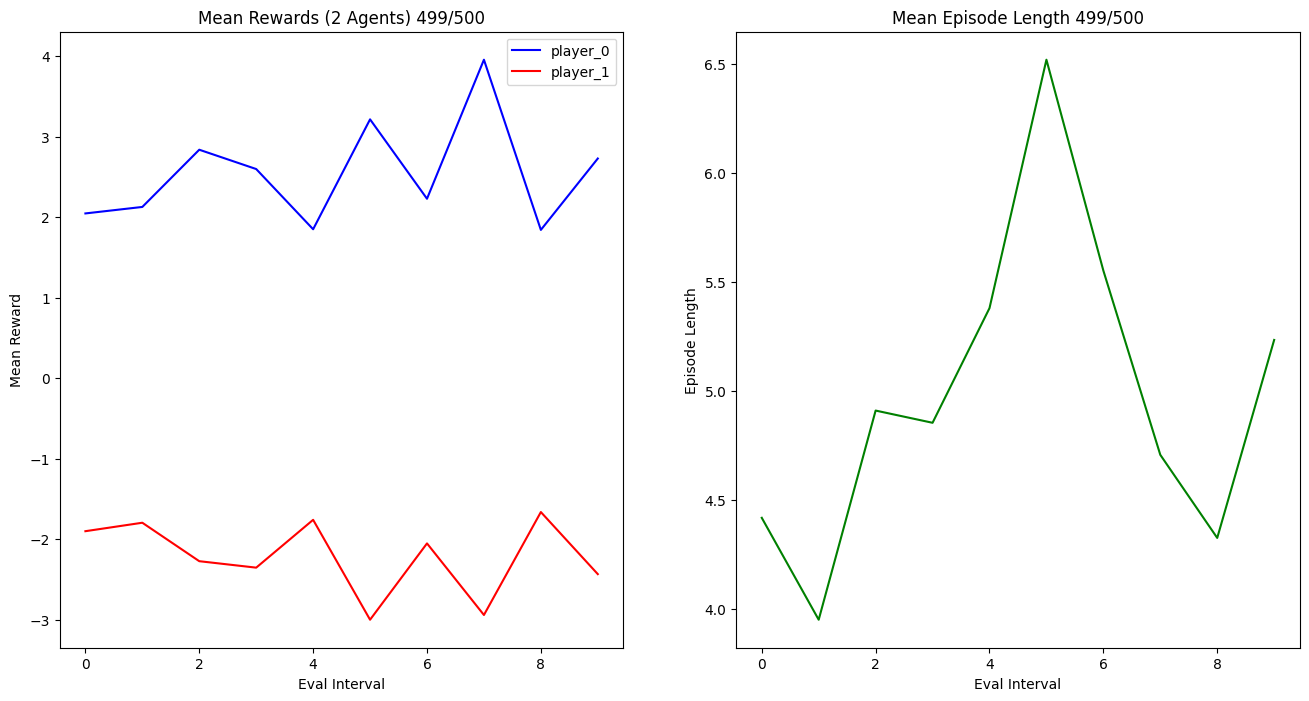

In [43]:
TRAINING_ITERATIONS = 500
import pickle
EVAL_INTERVAL = 50
from tqdm import tqdm

with tqdm(total=TRAINING_ITERATIONS, desc="Training", unit="iter") as pbar:
    for i in range(TRAINING_ITERATIONS):
        algo.train()

        if (i+1) % EVAL_INTERVAL == 0:
            # metrics = algo.evaluate()['evaluation']
            # rewards.append(metrics['episode_reward_mean'])
            # lengths.append(metrics['episode_len_mean'])
            metrics = algo.evaluate()
            metrics = metrics["env_runners"]

            # r_mean = metrics["episode_return_mean"]
            a1_reward.append(metrics["policy_reward_mean"]["learner"])
            a2_reward.append(metrics["policy_reward_mean"]["bot"])

            l_mean = metrics["episode_len_mean"]

            # rewards.append(r_mean)
            lengths.append(l_mean)
            plot_metrics(a1_reward, a2_reward, lengths, i, TRAINING_ITERATIONS)
            algo.save("./checkpoints_2")
        #pbar.update(1)

In [44]:
import numpy as np

SUITS = ["Spades", "Hearts", "Diamonds", "Clubs"]
RANKS = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "10", "J", "Q", "K"]

def decode_visible_cards(obs_dict):
    """Return list of human-readable cards visible to this player."""
    vec = obs_dict["observation"]
    # ensure it's a flat array
    vec = np.array(vec).astype(int)

    cards_bits = vec[:52]
    cards = []
    for i, bit in enumerate(cards_bits):
        if bit == 1:
            suit = SUITS[i // 13]
            rank = RANKS[i % 13]
            cards.append(f"{rank} of {suit}")
    return cards
ACTION_NAMES = {
    0: "Call",
    1: "Raise",
    2: "Fold",
    3: "Check",
}


In [46]:
import imageio
import torch
from PIL import Image

rmode = "rgb_array"

env = texas_holdem_v4.env(render_mode=rmode)
env.reset()
frames = []
for agent in env.agent_iter():
    print("-------------------")
    print(agent)
    obs, reward, termination, truncation, info = env.last()
    visible_cards = decode_visible_cards(obs)
    print("Visible cards:", visible_cards)
    print("Reward so far:", reward)

    if termination or truncation:
        action = None
        print("-------------------")
    else:
        rllib_obs = {
            "action_mask": obs["action_mask"],
            "observation": obs["observation"],
        }

        policy_id = "learner" if agent == "player_0" else "bot"

        action = algo.compute_single_action(
            rllib_obs,
            policy_id=policy_id,
            explore=False,
        )
        action_name = ACTION_NAMES.get(int(action), f"Unknown({action})")
        print("Chosen action:", action_name)
        print("-------------------")

    if rmode == "rgb_array":
        frame = env.render()
        if frame is not None:
            frames.append(frame)
    env.step(action)


env.close()


if rmode != "human":
   imageio.mimsave("ppo_poke.gif", frames, fps=2)
   print("Saved to ppo_poke.gif")

-------------------
player_0
Visible cards: ['9 of Spades', 'Q of Spades']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_1
Visible cards: ['6 of Hearts', '7 of Diamonds']
Reward so far: 0
Chosen action: Call
-------------------
-------------------
player_0
Visible cards: ['9 of Spades', 'Q of Spades', '2 of Clubs', '4 of Clubs', '8 of Clubs']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_1
Visible cards: ['6 of Hearts', '7 of Diamonds', '2 of Clubs', '4 of Clubs', '8 of Clubs']
Reward so far: 0
Chosen action: Call
-------------------
-------------------
player_0
Visible cards: ['9 of Spades', 'Q of Spades', 'A of Hearts', '2 of Clubs', '4 of Clubs', '8 of Clubs']
Reward so far: 0
Chosen action: Raise
-------------------
-------------------
player_1
Visible cards: ['A of Hearts', '6 of Hearts', '7 of Diamonds', '2 of Clubs', '4 of Clubs', '8 of Clubs']
Reward so far: 0
Chosen action: Call
-------------------
-